In [1]:
import random
import networkx as nx
from matplotlib import pyplot as plt
from collections import Counter
import math
from utils.plotTools import plot_qwak
import os
import ast
import numpy as np
import json

from scripts import load_list_from_file, write_list_to_file, load_or_generate_data, draw_graph, draw_graph_from_adjacency_matrix

In [2]:
def direct_sum(A, B):
    # Check if both matrices A and B are two-dimensional
    if A.ndim != 2 or B.ndim != 2:
        raise ValueError("Both input arrays should be two-dimensional")
        
    # Create zero matrices that match the dimensions of the other input
    zero_A = np.zeros((A.shape[0], B.shape[1]))
    zero_B = np.zeros((B.shape[0], A.shape[1]))
    
    # Concatenate these matrices appropriately to get the direct sum
    top = np.hstack([A, zero_A]) # top part of the direct sum
    bottom = np.hstack([zero_B, B]) # bottom part of the direct sum
    
    return np.vstack([top, bottom]) # final direct sum

In [3]:
def generate_triangular_graph(i):
    G = nx.Graph()
    G.add_edge(2*i, 2*i+2)
    G.add_edge(2*i+1, 2*i+2)
    return G

def generate_reverse_triangular_graph(i):
    G = nx.Graph()
    # Add edges based on the repetition count
    G.add_edge(3*i+2, 3*i+3)
    G.add_edge(3*i+2, 3*i+4)
    return G

def rotation_matrix():
    # Define the permutation matrix
    P = np.array([
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0]
    ])
    return P

In [4]:
def direct_sum_triangular_graph(repetitions):
    result_matrix = np.zeros((2,2))
    for i in range(repetitions):
        G = generate_triangular_graph(i)
        nodes = sorted(G.nodes())
        adjacency_matrix = nx.adjacency_matrix(G, nodelist=nodes).todense()        
        if i == 0:
            result_matrix = adjacency_matrix
        else:
            # Direct sum
            result_matrix = direct_sum(result_matrix, adjacency_matrix)

    return result_matrix

def direct_sum_reverse_triangular_graph(repetitions):
    # Initialize the result matrix to represent two disconnected nodes 0 and 1
    result_matrix = np.zeros((2,2))

    for i in range(repetitions-1):
        G = generate_reverse_triangular_graph(i)
        nodes = sorted(G.nodes())
        adjacency_matrix = nx.adjacency_matrix(G, nodelist=nodes).todense()
        
        # Direct sum
        result_matrix = direct_sum(result_matrix, adjacency_matrix)
    
    # After all repetitions, add an additional disconnected node
    result_matrix = direct_sum(result_matrix, np.zeros((1,1)))
    return result_matrix

def direct_sum_rotation_matrix(repetitions):
    p = rotation_matrix()
    result_matrix = p
    for i in range(repetitions-1):
        p = rotation_matrix()
        result_matrix = direct_sum(result_matrix, p)

    return result_matrix

def rotate_triangular(adjm,rotMat):
    rotated_matrix = np.dot(rotMat, np.dot(adjm, rotMat.T))
    return rotated_matrix

In [5]:
def add_new_vertex(adj_matrix, new_vertex_at_start, connect_to_vertices):
    """
    Adds a new vertex to the adjacency matrix at the beginning or the end and connects it to the specified vertices.
    """
    num_vertices = adj_matrix.shape[0] 
    # Create an extended adjacency matrix
    extended_adj_matrix = np.zeros((num_vertices + 1, num_vertices + 1))
    # Copy the original adjacency matrix into the extended one
    if new_vertex_at_start:
        extended_adj_matrix[1:, 1:] = adj_matrix
    else:
        extended_adj_matrix[:-1, :-1] = adj_matrix
    # Add connections from the new vertex to the specified vertices
    if new_vertex_at_start:
        for vertex in connect_to_vertices:
            extended_adj_matrix[0, vertex + 1] = extended_adj_matrix[vertex + 1, 0] = 1
    else:
        for vertex in connect_to_vertices:
            extended_adj_matrix[-1, vertex] = extended_adj_matrix[vertex, -1] = 1

    return extended_adj_matrix

def extend_rotation_matrix(rot_matrix, new_vertex_at_start):
    """
    Extends the rotation matrix with an additional row and column populated with an identity matrix,
    thereby ensuring that the added vertex is not rotated.
    """
    num_vertices = rot_matrix.shape[0]
    # Create an extended rotation matrix
    extended_rot_matrix = np.zeros((num_vertices + 1, num_vertices + 1))
    # Copy the original rotation matrix into the extended one
    if new_vertex_at_start:
        extended_rot_matrix[1:, 1:] = rot_matrix
        # Add identity element to the top-left corner of the extended rotation matrix
        extended_rot_matrix[0, 0] = 1
    else:
        extended_rot_matrix[:-1, :-1] = rot_matrix
        # Add identity element to the bottom-right corner of the extended rotation matrix
        extended_rot_matrix[-1, -1] = 1

    return extended_rot_matrix

def add_self_loops(adj_matrix):
    """
    Adds self-loops to each vertex in the adjacency matrix according to the number of its neighbors.
    """
    num_vertices = adj_matrix.shape[0]
    
    # Compute degree (number of neighbors) for each vertex
    degree = np.sum(adj_matrix, axis=1)

    # Add self-loops according to the degree
    for vertex in range(num_vertices):
        adj_matrix[vertex, vertex] = degree[vertex]

    return adj_matrix

def generate_temporal_helix(repetitions, timeSteps):
    triangularGraphMatrix = direct_sum_triangular_graph(repetitions=repetitions)
    reverseTriangularGraphMatrix = direct_sum_reverse_triangular_graph(repetitions=repetitions)

    graphMatrix = triangularGraphMatrix + reverseTriangularGraphMatrix
    rotationMatrix = direct_sum_rotation_matrix(repetitions)

    # Add L , c0 and R nodes.
    graphMatrix = add_new_vertex(graphMatrix, new_vertex_at_start = True, connect_to_vertices=[0, 1])
    graphMatrix = add_new_vertex(graphMatrix, new_vertex_at_start = True, connect_to_vertices=[0])
    graphMatrix = add_new_vertex(graphMatrix, new_vertex_at_start = False,connect_to_vertices=[-2])

    # Extend the rotation matrix to accommodate the new vertices
    rotationMatrix = extend_rotation_matrix(rotationMatrix, new_vertex_at_start=True)
    rotationMatrix = extend_rotation_matrix(rotationMatrix, new_vertex_at_start=True)
    rotationMatrix = extend_rotation_matrix(rotationMatrix, new_vertex_at_start=False)

    result_matrix = graphMatrix
    for _ in range(timeSteps):
        result_matrix = rotate_triangular(result_matrix, rotationMatrix)
    
    result_matrix = add_self_loops(result_matrix)
    return result_matrix


In [6]:
figsize = (10, 8)
k = 0.2
draw_self_loops = True

config = {
    'figsize': figsize,
    'k': k,
    'draw_self_loops': draw_self_loops,
    'node_color': 'orange',
    'node_size': 800,
    'normal_edge_color': 'blue',
    'normal_edge_width': 1.5,
    'edge_style': 'solid',
    'self_loop_color': 'red',
    'title': 'H_2_0'
}

config1 = {
    'figsize': figsize,
    'k': k,
    'draw_self_loops': draw_self_loops,
    'node_color': 'orange',
    'node_size': 800,
    'normal_edge_color': 'blue',
    'normal_edge_width': 1.5,
    'edge_style': 'solid',
    'self_loop_color': 'red',
    'title': 'H_2_1'
}

config2 = {
    'figsize': figsize,
    'k': k,
    'draw_self_loops': draw_self_loops,
    'node_color': 'orange',
    'node_size': 800,
    'normal_edge_color': 'blue',
    'normal_edge_width': 1.5,
    'edge_style': 'solid',
    'self_loop_color': 'red',
    'title': 'H_2_2'
}

rep = 4
temporal_helix = nx.from_numpy_array(generate_temporal_helix(rep,0))
print(len(temporal_helix))
print(f'{(3+rep*3)/2}')
# draw_graph(temporal_helix, config=config)

temporal_helix2 = nx.from_numpy_array(generate_temporal_helix(2,1))
# draw_graph(temporal_helix2, config=config1)

temporal_helix3 = nx.from_numpy_array(generate_temporal_helix(2,2))
# draw_graph(temporal_helix3, config=config2)


15
7.5


## Cover Time

In [82]:
def exponential_temporal_helix(rep,epsilon):
    n = (3+rep*3)/2
    copies = math.floor(n**(1-epsilon))
    graph0_2n = []
    graph1_2n = []    
    graph2_2n = []
    print(f'number of reps: {rep} \tnumber of copies: {copies}')
    for i in range(1,copies+1):
        graph0_2n.append(generate_temporal_helix(rep, 0))
        graph1_2n.append(generate_temporal_helix(rep, 1))
        graph2_2n.append(generate_temporal_helix(rep, 2))
            
    return graph0_2n,graph1_2n,graph2_2n


def multiple_exponential_temporal_helix(repetitions, epsilon):
    graphList = []
    for rep in repetitions:
        graph0,graph1,graph2 = exponential_temporal_helix(rep,epsilon)
        graphList.append(graph0+graph1+graph2)
    return graphList

def draw_matrices(matrices):
    for matrix in matrices:
        for i, m in zip(range(1,len(matrix)),matrix):
            np_matrix = np.array(m)  # Convert the list of lists to a numpy array
            G = nx.from_numpy_array(np_matrix)  # Create a NetworkX graph from the matrix

            plt.figure(i)  # Create a new figure for this graph
            nx.draw(G, with_labels=True, node_color='lightblue', font_weight='bold')  # Draw the graph
            plt.show()  # Display the figure
        
# gList = exponential_temporal_helix(2,1/2)
# nx.draw(nx.from_numpy_array(gList[0]))
# nx.draw(nx.from_numpy_array(gList[1]))
# nx.draw(nx.from_numpy_array(gList[2]))

# graph0,graph1,graph2 = exponential_temporal_helix(3,0.01)
# print(f'graph0 = {len(graph0)}\t graph1 = {len(graph1)}\t graph2 = {len(graph2)}')
# draw_graph(nx.from_numpy_array(graph0[0]), config=config)
# draw_graph(nx.from_numpy_array(graph0[1]), config=config)
# draw_graph(nx.from_numpy_array(graph1[0]), config=config1)
# draw_graph(nx.from_numpy_array(graph2[0]), config=config2)

# multipleTemp = multiple_exponential_temporal_helix(3,1/2)
# print(multipleTemp)
# for m in multipleTemp[3]:
#     print(m)
#     print(len(m))
#     print()

In [83]:
def temporal_graph_cover_time(n_range,epsilon):
    cover_times = []
    for n in n_range:
        n = n**epsilon
        cover_times.append(2**(n))
    return cover_times

def estimate_dynamic_cover_time(graphList, num_simulations=10):
    """
    Estimate the cover time of a list of evolving Sisyphus wheel graphs.

    Parameters:
    graphList (list): A 3D list of dynamic graphs.
    num_simulations (int): The number of simulations to perform.

    Returns:
    cover_times (list): A list of estimated cover times for each evolving graph.
    """

    cover_times = []

    for graphCopies in graphList:
        total_steps_for_all_simulations = 0
        n = len(graphCopies[0])  # Assume all graphs in the copy have the same number of nodes
        print(f'\nCalculatig cover time for n = {n}')

        for s in range(num_simulations+1):
            if s==0 or s==1 or s==10 or s==25 or s==35 or s==49:
                print(f'----> Sample number:{s}')
                
            visited = set()
            current_node = random.choice(range(n))
            total_steps_this_simulation = 0
            visited.add(current_node)
            # Loop continues until all nodes are visited
            while len(visited) < n:
                # Cycle through each graph in the graphCopies list in order
                graph = nx.from_numpy_array(graphCopies[total_steps_this_simulation % len(graphCopies)])
                # draw_graph(graph)
                # Choose a neighbor randomly
                neighbors = list(nx.neighbors(graph, current_node))
                if neighbors:
                    current_node = random.choice(neighbors)
                    
                # Add the current_node to visited if not already present
                if current_node not in visited:
                    visited.add(current_node)
                
                total_steps_this_simulation += 1
                last_vertex = list(graph.nodes())[-1]
                neighbors = list(graph.neighbors(last_vertex))
                # print(f'N={len(graph)} \t {neighbors[-1]} ---- {neighbors[0]}')


            # Accumulate the total steps for this simulation
            total_steps_for_all_simulations += total_steps_this_simulation

        # Average the total steps over the number of simulations
        average_cover_time = total_steps_for_all_simulations / num_simulations
        cover_times.append(average_cover_time)

    return cover_times

In [84]:
epsilon = 1/2
repMin = math.ceil(
    ((2*2**(1/(1-epsilon))) - 3)/3
)
reps = range(repMin,5*repMin)
multipleTemp = multiple_exponential_temporal_helix(reps,epsilon)

nrange = [math.ceil(len(g[0])/2) for g in multipleTemp]
nrange2 = [math.ceil(len(g[0])) for g in multipleTemp]
print(nrange)
samples = 25


cover_times_file = f'Datasets/DynGraphsDTRW/coverTimeTemporalHelix_N{nrange2[0]}-{nrange2[-1]}_EPS{epsilon}_S{samples}.txt'
estimate_cover_time_file = f'Datasets/DynGraphsDTRW/estimateCoverTimeTemporalHelix_N{nrange2[0]}-{nrange2[-1]}_EPS{epsilon}_S{samples}.txt'

if os.path.exists(cover_times_file) and os.path.exists(estimate_cover_time_file):
    cover_times = load_list_from_file(cover_times_file)
    estimate_cover_time = load_list_from_file(estimate_cover_time_file)
    print('File exists!')
else:
    print('File Doesnt Exist!')
    cover_times = estimate_dynamic_cover_time(multipleTemp, num_simulations=samples)
    estimate_cover_time = temporal_graph_cover_time(nrange,epsilon)
    if not os.path.exists(cover_times_file):
        write_list_to_file(cover_times_file, cover_times)
    if not os.path.exists(estimate_cover_time_file):
        write_list_to_file(estimate_cover_time_file, estimate_cover_time)


number of reps: 2 	number of copies: 2
number of reps: 3 	number of copies: 2
number of reps: 4 	number of copies: 2
number of reps: 5 	number of copies: 3
number of reps: 6 	number of copies: 3
number of reps: 7 	number of copies: 3
number of reps: 8 	number of copies: 3
number of reps: 9 	number of copies: 3
[5, 6, 8, 9, 11, 12, 14, 15]
File exists!


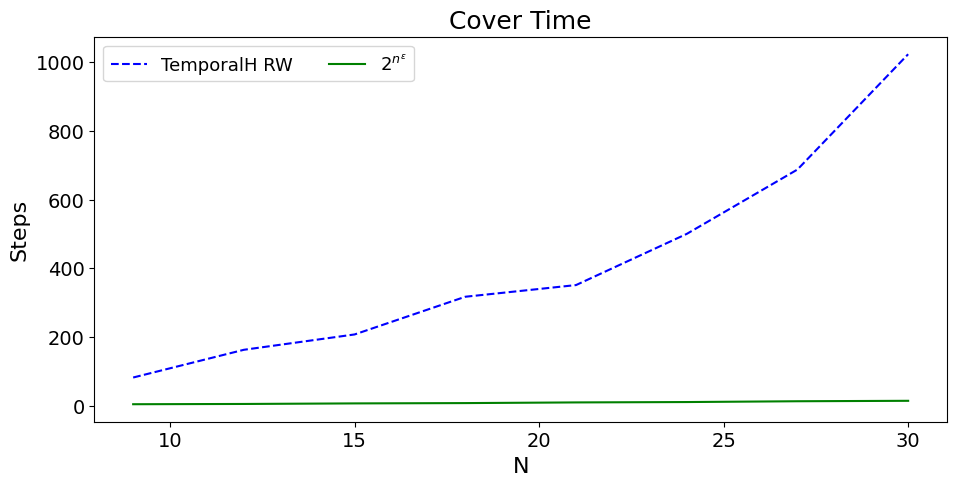

In [85]:
alphaLabelList = [r'TemporalH RW',r'$2^{n^\epsilon}$']

params = {
    'font_size' : 14,
    'figsize': (11, 5),
    'plot_title' : f'Cover Time',
    'x_label' : 'N',
    'y_label' : "Steps",
    'legend_labels' : alphaLabelList,
    'legend_loc': "best",
    # 'legend_title' : r'$\alpha$',
    'legend_ncol' : 3,
    'color_list' : ['#0000FF', '#008000', '#525252'],
    'line_style_list' : ['--', '-','-.' ],
    # 'save_path' : f'Output/OrientedDynamics/orientedDynamics_N{N}_NWALKS{len(alphaList)}_Alphas{str([round(a, 2) for a in alphaList]).replace(", ", "-").replace("[", "").replace("]", "")}_TMAX{round(t)}.png',
    'use_loglog': False,
    'use_cbar' : False,
    'cbar_label' : None, 
    'cbar_ticks' : None,
    'cbar_tick_labels' : None,
    'x_lim' : None,
    # 'x_num_ticks' : 7,
    # 'y_num_ticks' : 7,
    # 'x_round_val' : 1,
    # 'y_round_val' : 3,
}

node_value_matrix = list(nrange)
plot_qwak(x_value_matrix = [nrange2,nrange2] , y_value_matrix = [cover_times,estimate_cover_time],**params)